In [227]:
import numpy as np
import tensorflow as tf
import PIL.Image

In [228]:
def RGB_to_Y(x):
    x = tf.convert_to_tensor(x)
    x = tf.reshape(x,(3,32,32))
    x = tf.transpose(x,(1,2,0))
    x = tf.image.rgb_to_grayscale(x)
    return x
def display_Y(Y):
    return PIL.Image.fromarray(np.array(Y),'L')

In [229]:
X = tf.map_fn(RGB_to_Y,val["data"][0:500])

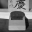

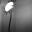

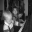

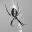

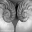

In [234]:
for i_img in range(5):
    img = display_Y(X[i_img,:,:,0])
    display(img)